In [ ]:
# Importing necessary libraries for file handling, data processing, machine learning, and text processing
!pip install dmba
import dmba
from pathlib import Path  # To handle file paths
from zipfile import ZipFile  # To work with zip files
import pandas as pd  # Data manipulation library
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer  # For converting text to a bag-of-words model
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfTransformer  # To apply TF-IDF transformation on bag-of-words model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  # For dimensionality reduction, used here for LSA
from sklearn.preprocessing import Normalizer  # To normalize the data after SVD
from sklearn.pipeline import make_pipeline  # To create a pipeline that applies multiple transformations in sequence
from sklearn.linear_model import LogisticRegression  # Logistic regression model for classification
import nltk  # Natural Language Toolkit for text processing
from nltk import word_tokenize  # For tokenizing text data into words
from nltk.stem.snowball import EnglishStemmer  # For stemming English words to their root forms
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pylab as plt  # For data visualization
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np
from nltk.util import ngrams
from collections import Counter

# Importing additional functions from the dmba library, possibly custom to the user environment
import dmba
from dmba import printTermDocumentMatrix, classificationSummary, liftChart  # Specific dmba functions

# Downloading the Punkt tokenizer models, necessary for word tokenization in NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Setting up inline plotting for Jupyter Notebook; displays plots directly below code cells
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


###**Question 1: Sample Text Analysis**

For these problems, use the following sample text:

The laptop was difficult to set up, and difficult to connect to the WIFI. I would go back to
using the previous laptop except it no longer charges.

a) Tokenize the sample text and display the tokens.

b) Determine and plot the word frequency for the sample text.

c) Filter out stop words from the tokens using NLTK's stop words list, then determine and plot
the word frequency of the filtered list.

d) Further process the tokens: filter out non-nouns, apply stemming, and plot the word frequency
of the processed tokens.

e) Using the SentimentIntensityAnalyzer from NLTK, determine the polarity scores of the
sample text.


Printing tokens:
The laptop was difficult to set up , and difficult to connect to the WIFI . I would go back to using the previous laptop except it no longer charges . 

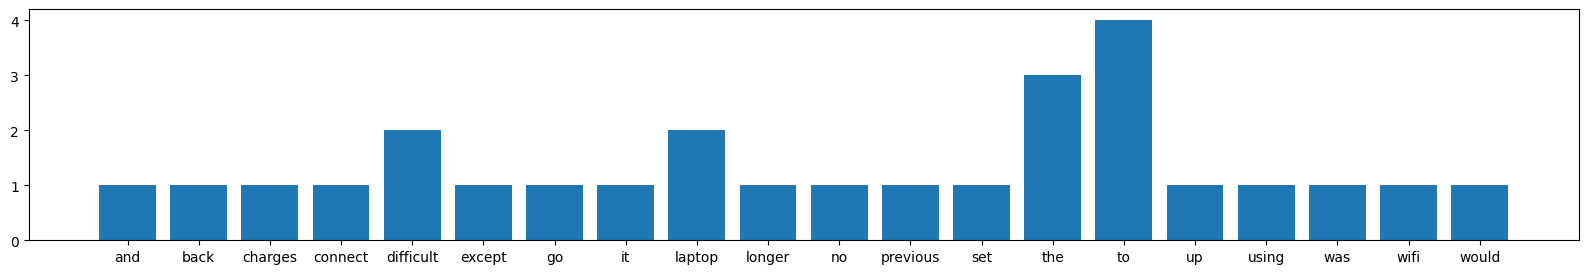

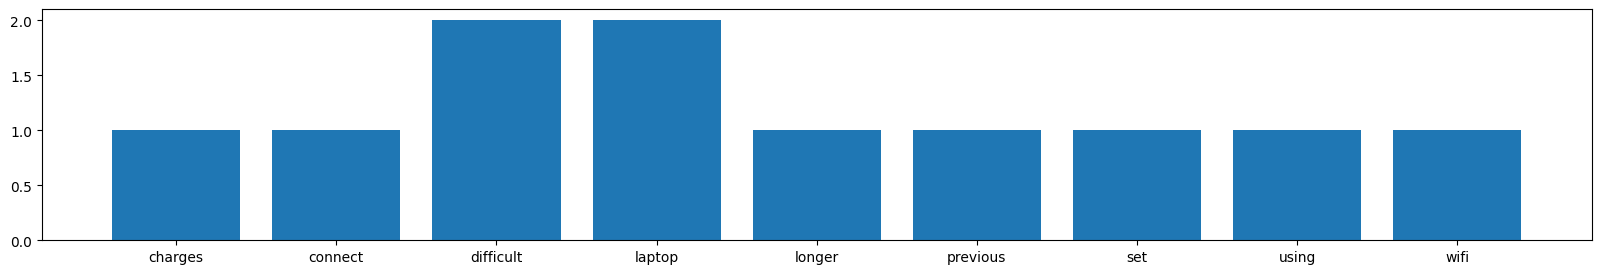

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


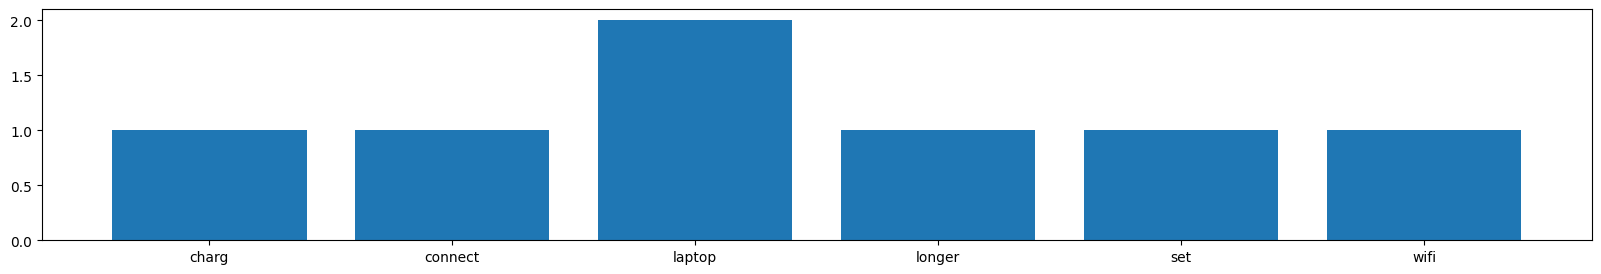

{'neg': 0.288, 'neu': 0.712, 'pos': 0.0, 'compound': -0.8074}


In [ ]:
input_text = "The laptop was difficult to set up, and difficult to connect to the WIFI. I would go back to using the previous laptop except it no longer charges."

def plot_freq(vect, count):
  plt.figure(figsize=(20,3))
  plt.bar(vect.get_feature_names_out(), np.ravel(count.sum(axis=0)))
  plt.show()

def print_tokens(vect):
  print("\nPrinting tokens:")
  for i, token in enumerate(vect):
    print(token, end=' ')

# tokenize sample text, display tokens
tokens = nltk.word_tokenize(input_text)
print_tokens(tokens)

# plot word frequency
count_vector = text.CountVectorizer()
count = count_vector.fit_transform([input_text])
plot_freq(count_vector, count)

# filter out stop words, plot word frequency
count_vector = text.CountVectorizer(stop_words='english')
count = count_vector.fit_transform([input_text])
plot_freq(count_vector, count)

# filter out non-nouns, stem, plot word frequency
class CustomTokenizer():
  def __init__(self):
    self.stemmer = EnglishStemmer()
    self.stop_words = ENGLISH_STOP_WORDS
    self.nouns = [
        'NN',
        'NNS',
        'NNP',
        'NNPS'
    ]

  def __call__(self, doc):
    return [self.stemmer.stem(t) for t in word_tokenize(doc)
      if t.isalpha() and t not in self.stop_words and nltk.pos_tag([t])[0][1] in self.nouns]
count_vector = text.CountVectorizer(tokenizer=CustomTokenizer())
count = count_vector.fit_transform([input_text])
plot_freq(count_vector, count)

# determine polarity score
sentiment = SentimentIntensityAnalyzer()
print(sentiment.polarity_scores(input_text))

###**Question 2: Tokenization**

Consider the following text version of a post to an online learning forum in a statistics course:

```
Thanks John!<br /><br /><font size=”3”>
&quot;Illustrations and demos will be
provided for students to work through on
their own&quot;</font>.
Do we need that to finish project? If yes,
where to find the illustration and demos?
Thanks for your help.\<img title=”smile”
alt=”smile” src=”\url{http://lms.statistics.
com/pix/smartpix.php/statistics_com_1/s/smil
ey.gif}” \><br /> <br />
```

a) Identify 10 non-word tokens in the passage.

b) Suppose this passage constitutes a document to be classified, but you are not certain of the business goal of the classification task. Identify material (at least
20% of the terms) that, in your judgment, could be discarded fairly safely without knowing that goal.

c) Suppose the classification task is to predict whether this post requires the attention of the instructor, or whether a teaching assistant might suffice. Identify
the 20% of the terms that you think might be most helpful in that task.

d) What aspect of the passage is most problematic from the standpoint of simply using a bag-of-words approach, as opposed to an approach in which meaning is extracted?

In [ ]:
input_text = r"""Thanks John!<br /><br /><font size=”3”>
&quot;Illustrations and demos will be
provided for students to work through on
their own&quot;</font>.
Do we need that to finish project? If yes,
where to find the illustration and demos?
Thanks for your help.\<img title=”smile”
alt=”smile” src=”\url{http://lms.statistics.
com/pix/smartpix.php/statistics_com_1/s/smil
ey.gif}” \><br /> <br />” \><br /> <br />"""

# identify 10 non-word tokens
tokens = word_tokenize(input_text)
non_word_tokens = [t for t in tokens if not t.isalpha()]
for i, t in enumerate(non_word_tokens):
  if(i == 10):
    break
  print(t, end=' ')

# material that may be safely discarded could include the html tags and characters
# ex: </font> &quot; <br />
# html tags are used for print formatting and are not indicative of the text content itself

# key terms for a classification task may include illustration, demos, project, work, help
# this can be described as specific verbage and nouns

# the most problematic passage for a bag-of-words approach would be the specification
# of certain tasks to be performed "on their own" and conditional instructions, such as
# the "If yes" to needing to finish the project
# bag of words removes context which makes interpretation of instructions difficult

! < / > < / > < size= ” 

###**Question 3: Classifying Internet Discussion Posts**

In this problem, you will develop a model to classify documents as either auto-related or electronics-related using the provided dataset, "AutoAndElectronics.zip."

a) Load the zipped file into Python and create a label vector where the labels are 1 for auto-related posts and 0 for electronics-related posts. (Hint: Use the zipfile
module to open the zip file and process the text files inside. Create labels based on the folder names where the documents are stored).

b) Preprocess the documents by tokenizing the text, removing stop words, and applying stemming. Explain what would be different if you did not perform the
“stemming” step in preprocessing.

c) Use Latent Semantic Analysis (LSA) to create 10 concepts from the preprocessed documents. (Hint: You can use TruncatedSVD from sklearn to perform LSA). Explain how the concept matrix differs from the Term Frequency-
Inverse Document Frequency (TF-IDF) matrix.

d) Using the concept matrix generated in step (c), fit a predictive model (such as SVM or Logistic Regression) to classify the documents as autos or electronics. Compare its performance to another model by calculating accuracy, precision, recall, and f1-score.

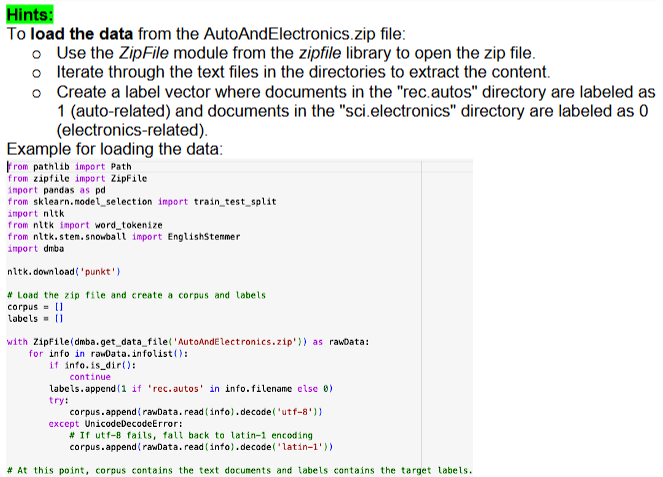

In [ ]:
input_text = []
labels = []

# load data into input_text and label vectors
with ZipFile(dmba.get_data_file('AutoAndElectronics.zip')) as data:
  for d in data.infolist():
    if (d.is_dir()):
      continue

    if('rec.autos' in d.filename):
      labels.append(1)
    else:
      labels.append(0)

    try:
      input_text.append(data.read(d).decode('utf-8'))
    except UnicodeDecodeError:
      input_text.append(data.read(d).decode('latin-1'))

# preprocessing (tokenize, stop words, stemming)
stop_words = set(stopwords.words('english'))
port_stemmer = PorterStemmer()
tokens = [[port_stemmer.stem(t) for t in word_tokenize(doc) if t.isalpha() and t not in stop_words] for doc in input_text]
processed = tokens

# if stemming was not performed in this step, different variations of the same token could not be clumped together
# ex: "jumped" and "jumping" would be two separate items, instead of both being of type "jump"

# concept creation via LSA
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(input_text)
lsa = TruncatedSVD(n_components=10)
concepts = lsa.fit_transform(x_tfidf)

# predictive model for document classification, print stats
x_train, x_test, y_train, y_test = train_test_split(concepts, labels, test_size=0.4, random_state=42)
regression = LogisticRegression()
regression.fit(x_train, y_train)
y_pred = regression.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.92125
Precision: 0.9497354497354498
Recall: 0.890818858560794
F1 Score: 0.9193341869398207


###**Question 4: Classifying Classified Ads Submitted Online**

Consider the case of a website that caters to the needs of a specific farming community, and carries classified ads intended for that community. Anyone, including robots, can post an ad via a web interface, and the site owners have problems with ads that are fraudulent, spam, or simply not relevant to the community. They have provided a file with 4143 ads, each ad in a row, and each ad labeled as either − 1 (not relevant) or 1
(relevant). Use the dmba library to load the dataset. The dataset should be loaded with no header.

Hint:
```
import dmba
df = dmba.load_data('farm-ads.csv', header=None)
```

The goal is to develop a predictive model that can classify ads automatically.

o Open the file farm-ads.csv, and briefly review some of the relevant and non-relevant ads to get a flavor for their contents.

o Preprocess the data in Python, and create a term-document matrix, and a concept matrix. Limit the number of concepts to 20.

a) Examine the term-document matrix.

I. Is it sparse or dense?

II. Find two non-zero entries and briefly interpret their meaning, in words (you do not need to derive their calculation).

b) Briefly explain the difference between the term-document matrix and the concept-document matrix. Relate the latter to what you learned in the principal components chapter.

c) Using logistic regression, partition the data (60% training, 40% validation), and develop a model to classify the documents as “relevant” or “non-relevant.” Comment on its efficacy.

d) Why use the concept-document matrix, and not the term-document matrix, to provide the predictor variables?


In [ ]:
# open data file
df = dmba.load_data('farm-ads.csv', header=None)
x = df[1].tolist()
y = df[0].tolist()

# preprocessing
stop_words = set(stopwords.words('english'))
port_stemmer = PorterStemmer()
tokens = [[port_stemmer.stem(t) for t in word_tokenize(doc) if t.isalpha() and t not in stop_words] for doc in x]
x_processed = tokens

# term-document matrix
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(x)

if(x_tfidf.getnnz() / x_tfidf.size > 0.5):
  print('Term-document matrix is dense')
else:
  print('Term-document matrix is sparse')

# find two non-zero entries, interpret meaning
doc_index = 0
word_index = 1
print(f'Document {doc_index} with word {tfidf.get_feature_names_out()[word_index]} contains value {x_tfidf[doc_index, word_index]}')
print(f'Word {tfidf.get_feature_names_out()[word_index]} is present in document {doc_index} at a frequency of {x_tfidf[doc_index, word_index]}')

# concept-document matrix is representatve of the lower-dim space, where column = concept
# this relates to PCA, where column = variance direction

# classify documents with logistic regression model
lsa = TruncatedSVD(n_components=20)
concepts = lsa.fit_transform(x_tfidf)
x_train, x_test, y_train, y_test = train_test_split(concepts, labels, test_size=0.4, random_state=42)
regression = LogisticRegression()
regression.fit(x_train, y_train)
y_pred = regression.predict(x_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
# the model cannot handle negative values as well but otherwise does a god job
# the concept-document matrix does a better job at predictor variables because it allows for
# understanding context/connections/relationships

Term-document matrix is dense
Document 0 with word aaa contains value 0.29564533457586817
Word aaa is present in document 0 at a frequency of 0.29564533457586817


###**Question 5: Clustering Auto Posts**

In this problem, you will use a dataset containing internet discussion posts that are either auto-related or electronics-related. Your task is to cluster the auto-related posts. You will use text preprocessing, Latent Semantic Analysis (LSA), and clustering
techniques like hierarchical clustering and k-means clustering. To get started, first load the data from the **AutoAndElectronics.zip** file. You will focus on the **auto-related** posts only.

**Instructions:**

**a) Preprocess the documents, without creating a label vector.**

• Preprocessing should include steps like tokenization, removal of stop words, and applying stemming or lemmatization. Be sure to explain your preprocessing
steps.

**b) Use Latent Semantic Analysis (LSA) to create 10 concepts.**

• After preprocessing, apply LSA to the term-document matrix to reduce the data to 10 concepts (latent dimensions). This will help with clustering later.

**c) Before clustering, estimate how many natural clusters you expect to find.**

• Based on your understanding of the data, state how many clusters you expect the algorithm to uncover. Justify your estimate.

**d) Perform hierarchical clustering and inspect the dendrogram.**

• Perform hierarchical clustering on the LSA-reduced data and visualize the results using a dendrogram. Explain any patterns or insights you observe.

**e) From the dendrogram, how many natural clusters appear?**

• Based on the dendrogram, determine how many natural clusters you can identify. Explain your reasoning.

**f) Select a sub-cluster from the dendrogram and assess its characteristics.**

• Examine one sub-cluster from the dendrogram. Analyze the contents of the posts in this sub-cluster and describe any common themes or characteristics that these
posts share.

**g) Perform k-means clustering for two clusters and evaluate their separation.**

• Perform k-means clustering on the dataset, setting the number of clusters to 2. Report the between-cluster distance and within-cluster dispersion. Comment on
how well-separated the clusters are.

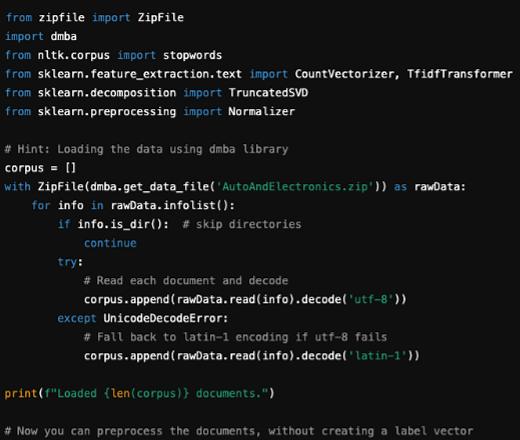

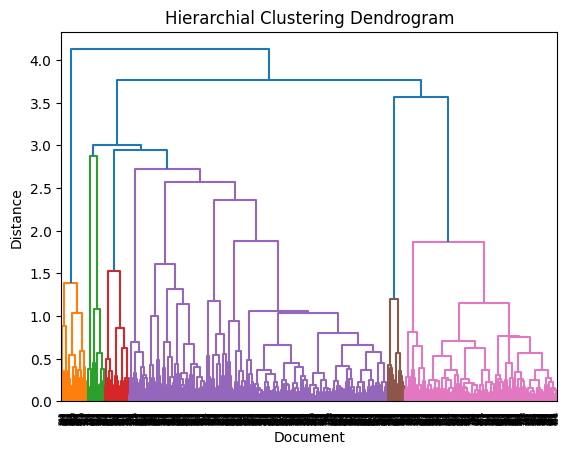

Characteristics of the chosen sub-cluster:
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!zaphod.mps.ohio-state.edu!usc!elroy.jpl.nasa.gov!nntp-server.caltech.edu!lxrosser
From: lxrosser@cco.caltech.edu (Alex Rosser)
Newsgroups: rec.autos
Subject: Re: What is " Volvo " ?
Message-ID: <1pl86tINNfv7@gap.caltech.edu>
Date: 3 Apr 93 23:56:12 GMT
Article-I.D.: gap.1pl86tINNfv7
References: <1993Mar31.193406.29625@ugle.unit.no> <1993Apr1.174233.29988@newsgate.sps.mot.com>
Organization: California Institute of Technology, Pasadena
Lines: 27
NNTP-Posting-Host: blacker.caltech.edu

wolfson@regatta.sps.mot.com (Stephen Wolfson) writes:

>In article <1993Mar31.193406.29625@ugle.unit.no> oep@colargol.edb.tih.no  
>(oep) writes:
>> which turns into a teenagers car when it gets old. The average  
>lifelength of
>> a Volvo in Norway is 18 years, and in Sweden 20 years)

>Of course someone pointed out when Saab or Volvo was running their
>At least 10 years ads, that the average mila

In [ ]:
input_text = []

# load data into input_text vector
with ZipFile(dmba.get_data_file('AutoAndElectronics.zip')) as data:
  for d in data.infolist():
    if (d.is_dir() or 'rec.autos' not in d.filename):
      continue

    try:
      input_text.append(data.read(d).decode('utf-8'))
    except UnicodeDecodeError:
      input_text.append(data.read(d).decode('latin-1'))

# preprocessing (tokenize, stop words, stemming)
stop_words = set(stopwords.words('english'))
port_stemmer = PorterStemmer()
tokens = [[port_stemmer.stem(t) for t in word_tokenize(doc) if t.isalpha() and t not in stop_words] for doc in input_text]

# concept creation via LSA
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(input_text)
lsa = TruncatedSVD(n_components=10)
concepts = lsa.fit_transform(x_tfidf)

# I estimate the number of clusters to be between 6 and 10

# hierarchial clustering + dendrogram
link = linkage(concepts, 'ward')
dendrogram(link)
plt.title('Hierarchial Clustering Dendrogram')
plt.xlabel('Document')
plt.ylabel('Distance')
plt.show()

# The dendrogram has identified six colors/clusters

# select a subcluster, examine
labels = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(concepts)
clust = [input_text[d] for d in range(len(input_text)) if labels[d]==2]

print('Characteristics of the chosen sub-cluster:')
for i in clust[:3]:
  print(i, '\n')

# Common characteristics include the month of April 93, news group 'rec.auto', sent by a 'Net Noise owner'

# kmeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
y_pred = kmeans.fit_predict(concepts)
between_clust = np.sqrt(kmeans.inertia_)
within_clust = np.mean(kmeans.transform(concepts))
print(f'Between-cluster distance: {between_clust}')
print(f'Within-cluster dispersion: {within_clust}')

# Clusters are fairly optimized (well separated, tight within-clusters)

###**Question 6: Discovering Frequent Word Sequences in Text**

In this task, you will perform sequence mining by identifying frequent word sequences (n-grams) in a set of documents from the "AutoAndElectronics" dataset. You will find frequent 3-word sequences (trigrams) and explain the patterns they reveal about the topics discussed in the posts.

**Instructions:**

a) Load the "AutoAndElectronics.zip" dataset using the dmba library, and focus on the electronics-related posts (i.e., those labeled as 0).

b) Preprocess the text data by tokenizing, removing stop words, and applying stemming.

c) Identify and display the 10 most frequent trigrams (three-word sequences) in the electronics-related posts.

d) Briefly describe any patterns or insights these frequent trigrams suggest about the
electronics posts

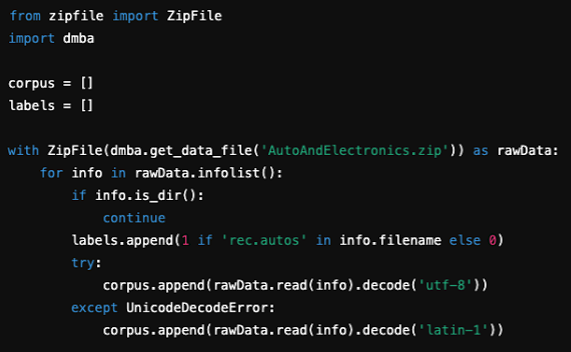

In [ ]:
input_text = []

# load dataset
with ZipFile(dmba.get_data_file('AutoAndElectronics.zip')) as data:
  for d in data.infolist():
    if (d.is_dir() or 'sci.electronics' not in d.filename):
      continue

    try:
      input_text.append(data.read(d).decode('utf-8'))
    except UnicodeDecodeError:
      input_text.append(data.read(d).decode('latin-1'))

# preprocessing (tokenize, stop words, stemming)
stop_words = set(stopwords.words('english'))
port_stemmer = PorterStemmer()
tokens = [[port_stemmer.stem(t) for t in word_tokenize(doc) if t.isalpha() and t not in stop_words] for doc in input_text]

# locate trigrams and patterns
tris = [tuple(tokens[i][j:j+3]) for i in range(len(tokens)) for j in range(len(tokens[i])-2)]
top_ten_tris = Counter(tris).most_common(10)
print('Top 10 Trigrams:')
for tri, i in top_ten_tris:
  print(f'{" ".join(tri)} : {i}')

# Some recognized patterns/insights include date specification, annual reports, and meeting to discuss reports

Top 10 Trigrams:
apr gmt line : 425
date apr gmt : 316
newsgroup subject re : 289
line in articl : 249
path rochest udel : 185
apr gmt organ : 168
apr gmt refer : 144
gmt line in : 136
date mon apr : 130
date tue apr : 130
